In [1]:
from torch.utils.data import *
from lircst_ana_dataset import LircstAnaDataset
from torch import Generator

dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')

rand_generator = Generator().manual_seed(42) # The meaning of life, the universe and everything

dataset_train, dataset_valid, dataset_test = random_split(dataset, [0.8, 0.1, 0.1], generator=rand_generator)

In [2]:
import pytorch_lightning as pl
from lircst_ana_dataset import LircstAnaDataset
from encoded_conditional_diffusion import ECDiffusion
from Diffusion.EMA import EMA
from Diffusion.DenoisingDiffusionProcess.samplers import DDIM_Sampler
from Diffusion.DenoisingDiffusionProcess.samplers import DDPM_Sampler


model = ECDiffusion(
    train_dataset=dataset_train,
    valid_dataset=dataset_valid,
    test_dataset=dataset_test,
    lr=1e-4,
    batch_size=16,
)

# Load the model from a checkpoint
# Comment out the line below if you want to start training from scratch
#'''
model = ECDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_16/checkpoints/epoch=172-step=200000.ckpt",
                                         train_dataset=dataset_train,
                                         valid_dataset=dataset_valid,
                                         test_dataset=dataset_test,
                                         lr=1e-4,
                                         batch_size=16,)
#'''

# Seems like the inference-time DDIM sampler that they provided is bugged
#ddpm_sampler=DDPM_Sampler(model.model.train_timesteps)
#model.model.diffusion_process.sampler = ddpm_sampler


trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    accelerator='gpu',
    devices=[0],
    check_val_every_n_epoch=10,
)

/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is Time embed used ?  True
Is Time embed used ?  True


/home/samnub/dev/lircst-diffusion/src/Diffusion/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train an untrained model

trainer.fit(model)

In [ ]:
# Evaluate the model

trainer.test(model)

In [1]:
# Use the model

import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from encoded_conditional_diffusion import ECDiffusion
from lircst_ana_dataset import LircstAnaDataset
from Diffusion.DenoisingDiffusionProcess.samplers import DDIM_Sampler
from Diffusion.DenoisingDiffusionProcess.samplers import DDPM_Sampler


dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')


trained_model = ECDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_16/checkpoints/epoch=172-step=200000.ckpt",
                                                 train_dataset = dataset,
                                                 lr=1e-4,
                                                 batch_size=16,)

trained_model.cuda()
trained_model.eval()

phan, sino, _ = dataset[6999]
sino = torch.from_numpy(sino)
batch_input = torch.stack(4*[sino]).cuda()

/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is Time embed used ?  True
Phantom 1746593815 slice 72 - phan[0] range: 0.0 - 4.6781496373249634e+24
Phantom 1746593815 slice 72 - phan[1] range: 0.0 - 0.07686000317335129
Phantom 1746593815 slice 72 - sino range: 0.0 - 0.0048683162904597345
Phantom 1746593815 slice 72 - phan[0] range: -1.0 - 1.0
Phantom 1746593815 slice 72 - phan[1] range: -1.0 - 1.0
Phantom 1746593815 slice 72 - sino range: -1.0 - 1.0


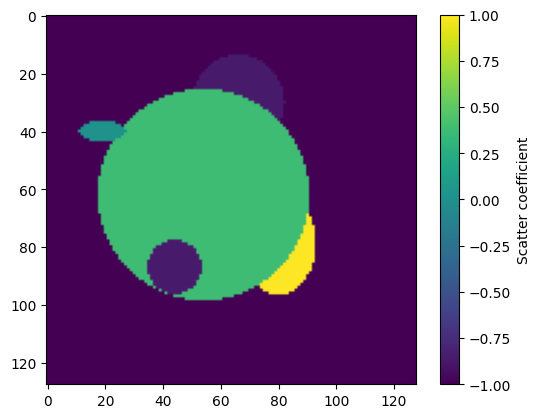

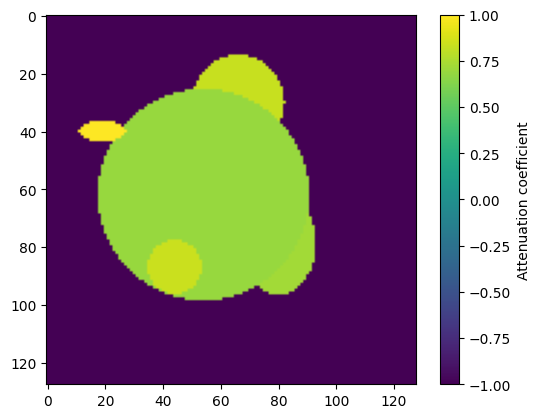

GT range:
-1.0 1.0
-1.0 1.0
Input range:
tensor(-1.) tensor(1.)


In [2]:
plt.imshow(phan[0])
plt.colorbar(label="Scatter coefficient")
plt.show()
plt.imshow(phan[1])
plt.colorbar(label="Attenuation coefficient")
plt.show()

print("GT range:")
print(phan[0].min(), phan[0].max())
print(phan[1].min(), phan[1].max())
# Also print the range of the input
print("Input range:")
print(sino.min(), sino.max())

diffusion sampling: 100%|██████████| 200/200 [00:06<00:00, 29.01it/s]


torch.Size([4, 2, 128, 128])
0.10076676447138509
0.05127551807700335
Output range:
-0.91133845 0.12610614
Encoded condition range:
-1.0 0.9988242


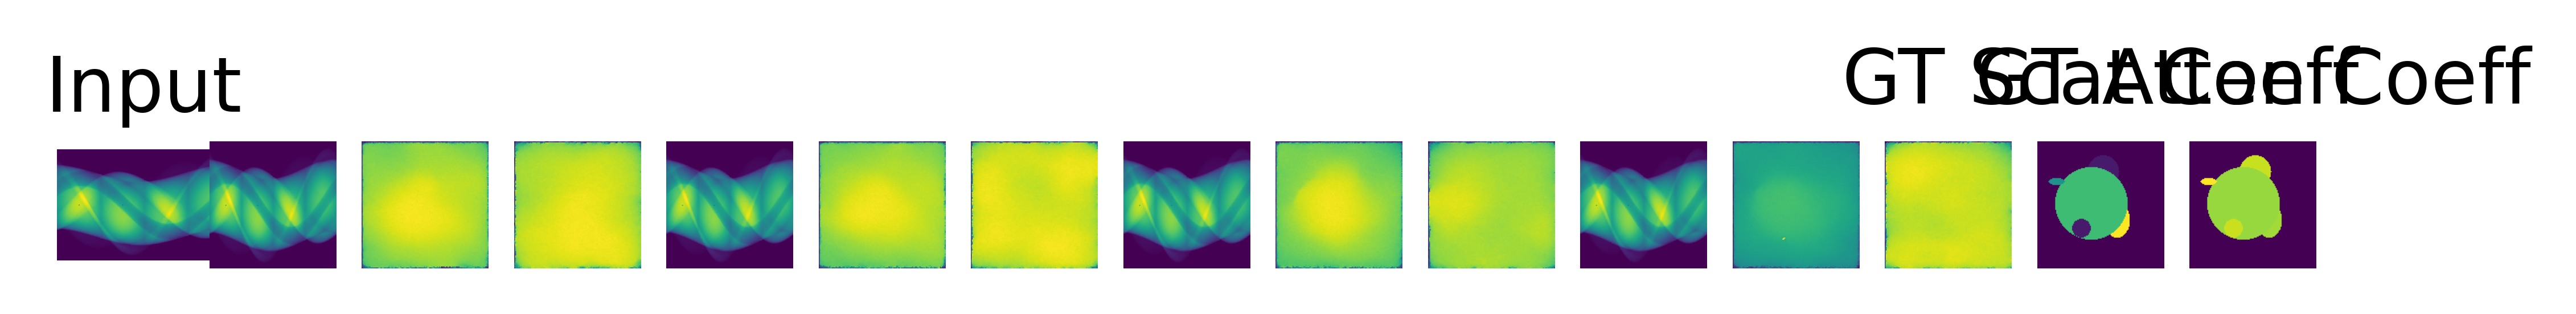

In [3]:
# Seems like the inference-time DDIM sampler that they provided is bugged
#ddpm_sampler=DDPM_Sampler(trained_model.model.train_timesteps)
#trained_model.model.diffusion_process.sampler = ddpm_sampler

out, encoded_condition = trained_model(batch_input, verbose=True)

print(out.shape)


plt.figure(dpi=800)
plt.subplot(1,3+len(out)*2,1)
plt.imshow(torch.sum(sino, axis=2))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]*3):
    if idx % 3 == 1:
        continue
    if idx % 3 == 2:
        continue
    plt.subplot(1,3+len(out)*3,idx+2)
    plt.imshow(torch.sum(encoded_condition[idx//3].detach().cpu(), axis=0))
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,idx+3)
    plt.imshow(out[idx//3].detach().cpu()[0])
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,idx+4)
    plt.imshow(out[idx//3].detach().cpu()[1])
    plt.axis('off')
plt.subplot(1,3+len(out)*3,2+len(out)*3)
plt.imshow(phan[0])
plt.title('GT Scat Coeff')
plt.axis('off')
plt.subplot(1,3+len(out)*3,3+len(out)*3)
plt.imshow(phan[1])
plt.title('GT Atten Coeff')
plt.axis('off')


# Compare with GT using SSIM
from skimage.metrics import structural_similarity as ssim

def compare_images(imageA, imageB):
    # Compute SSIM between two images
    
    # If images aren't the same size, resize them
    if imageA.shape != imageB.shape:
        imageA = np.resize(imageA, imageB.shape)

    # P.S. Scikit-image returns a value between -1 and 1, where 1 is a perfect match and -1 is a complete mismatch
    s = ssim(imageA, 
             imageB, 
             multichannel=True,
             data_range=imageB.max() - imageB.min())
    return s

print(compare_images(out[0].detach().cpu().numpy()[0], phan[0]))
print(compare_images(out[0].detach().cpu().numpy()[1], phan[1]))

# Also print the range of the output
print("Output range:")
print(out[0].detach().cpu().numpy()[0].min(), out[0].detach().cpu().numpy()[0].max())
# Also print the range of the encoded condition
print("Encoded condition range:")
print(encoded_condition[0].detach().cpu().numpy()[0].min(), encoded_condition[0].detach().cpu().numpy()[0].max())